In [1]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reuse some code of SKLearn documentation

We see how the Dictionary Learning is supposed to work on some basic sparse signal.

In [2]:
n_samples = 1000
n_features = 2

X, dictionary, code = make_sparse_coded_signal(
    n_samples=n_samples, n_components=15, n_features=n_features, n_nonzero_coefs=10,
    random_state=42,
)
print(f"The sparse signals dataset is made of {X.shape[1]} samples of size {X.shape[0]} each.")
print("Sample 0 from X:", X[:, 0])

dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', random_state=42,
)
X_transformed = dict_learner.fit_transform(X)

The sparse signals dataset is made of 1000 samples of size 2 each.
Sample 0 from X: [2.19620009 3.9065111 ]


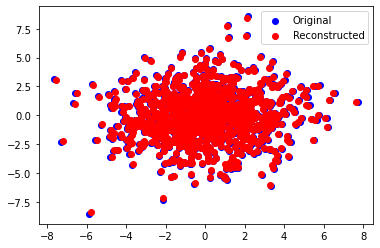

In [3]:
plt.scatter(X[0,:], X[1, :], color="blue", label="Original")

X_hat = X_transformed @ dict_learner.components_
plt.scatter(X_hat[0,:], X_hat[1, :], color="red", label="Reconstructed")

plt.legend()
plt.show()

In [4]:
np.mean(X_transformed == 0)

X_hat = X_transformed @ dict_learner.components_
np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

0.0002138652048926348

## Study evolution of error with time/new samples

In [19]:
n_samples = 10000
n_features = 2

X, dictionary, code = make_sparse_coded_signal(
    n_samples=n_samples, n_components=15, n_features=n_features, n_nonzero_coefs=10,
    random_state=42,
)

def study_evolution_dictionary_through_time(X, n_samples_range):
    dictionaries = []
    for n_samples in tqdm(n_samples_range):
        dict_learner = DictionaryLearning(
            n_components=15, transform_algorithm='lasso_lars', random_state=42,
        )
        dict_learner.fit(X[:n_samples])
        
        dictionaries.append(dict_learner)
    
    return dictionaries


def study_evolution_error_through_time(X, n_samples_range):
    losses = []
    for n_samples in tqdm(n_samples_range):
        X_data = X[:, :n_samples]
        dict_learner = DictionaryLearning(
            n_components=15, transform_algorithm='lasso_lars', random_state=42,
        )
        X_transformed = dict_learner.fit_transform(X_data)
        X_hat = X_transformed @ dict_learner.components_
        
        loss = np.mean(np.sum((X_hat - X_data)[:10] ** 2, axis=1) / np.sum(X_data[:10] ** 2, axis=1))
        losses.append(loss)
    
    return losses


n_samples_log_range = np.logspace(1, 5, 20).astype(int)
# all_dictionaries = study_evolution_dictionary_through_time(X, n_samples_log_range)

In [20]:
l2_losses = study_evolution_dictionary_through_time(X, n_samples_log_range)

100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


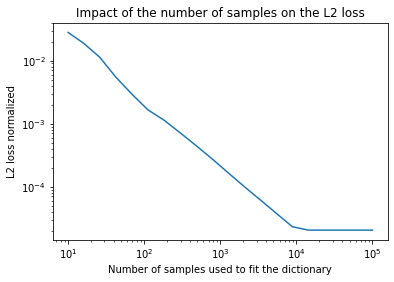

In [23]:
plt.loglog(n_samples_log_range, l2_losses)
plt.xlabel("Number of samples used to fit the dictionary")
plt.ylabel("L2 loss normalized")
plt.title("Impact of the number of samples on the L2 loss")
plt.show()

# Evaluate parameters

In [3]:
import numpy as np

from online_learning import eval_n_components, eval_alpha
from online_learning.visualizations import plot_alphas_losses_sparsities, plot_n_components_losses_sparsities
from online_learning.datasets import make_sparse_data

In [4]:
n_samples = 1000
n_features = 2

X = make_sparse_data(n_samples, n_features)

In [7]:
X

array([[ 2.19620009,  0.20373813, -0.84070862, ...,  2.34820895,
         1.93341199, -1.15443101],
       [ 3.9065111 , -1.35778536,  1.44424431, ...,  0.92921493,
        -1.56862175, -2.14824326]])

100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


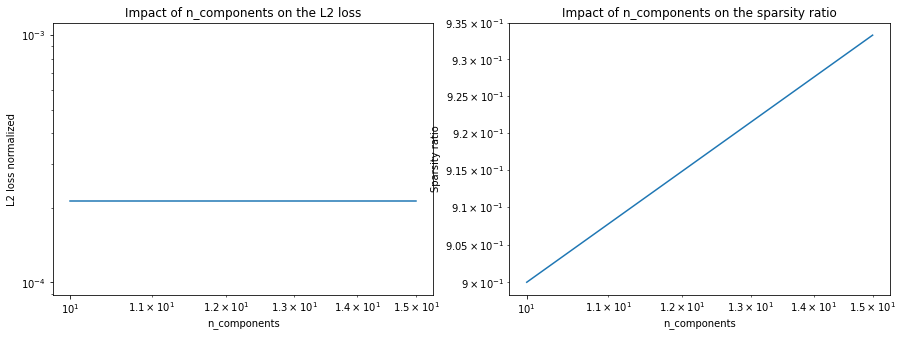

In [3]:
losses, sparse_ratios = eval_n_components([10, 15], X)

plot_n_components_losses_sparsities([10, 15], losses, sparse_ratios)

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


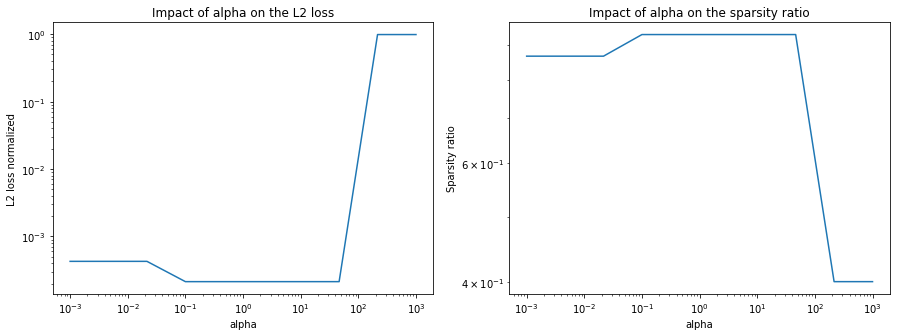

In [6]:
alphas = np.logspace(-3, 3, 10)
losses_alphas, sparse_alphas = eval_alpha(alphas, X)
    
plot_alphas_losses_sparsities(alphas, losses_alphas, sparse_alphas)

## FaceAll dataset

In [1]:
from online_learning.datasets import make_faces
from sklearn.decomposition import DictionaryLearning

X, y = make_faces()

In [2]:
print(X.shape)

(2250, 131)


In [3]:
dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', random_state=42,
)
dict_learner.fit(X)

DictionaryLearning(n_components=15, random_state=42,
                   transform_algorithm='lasso_lars')

(2250, 131) (2250, 15) (15, 131)
Label: 3
15


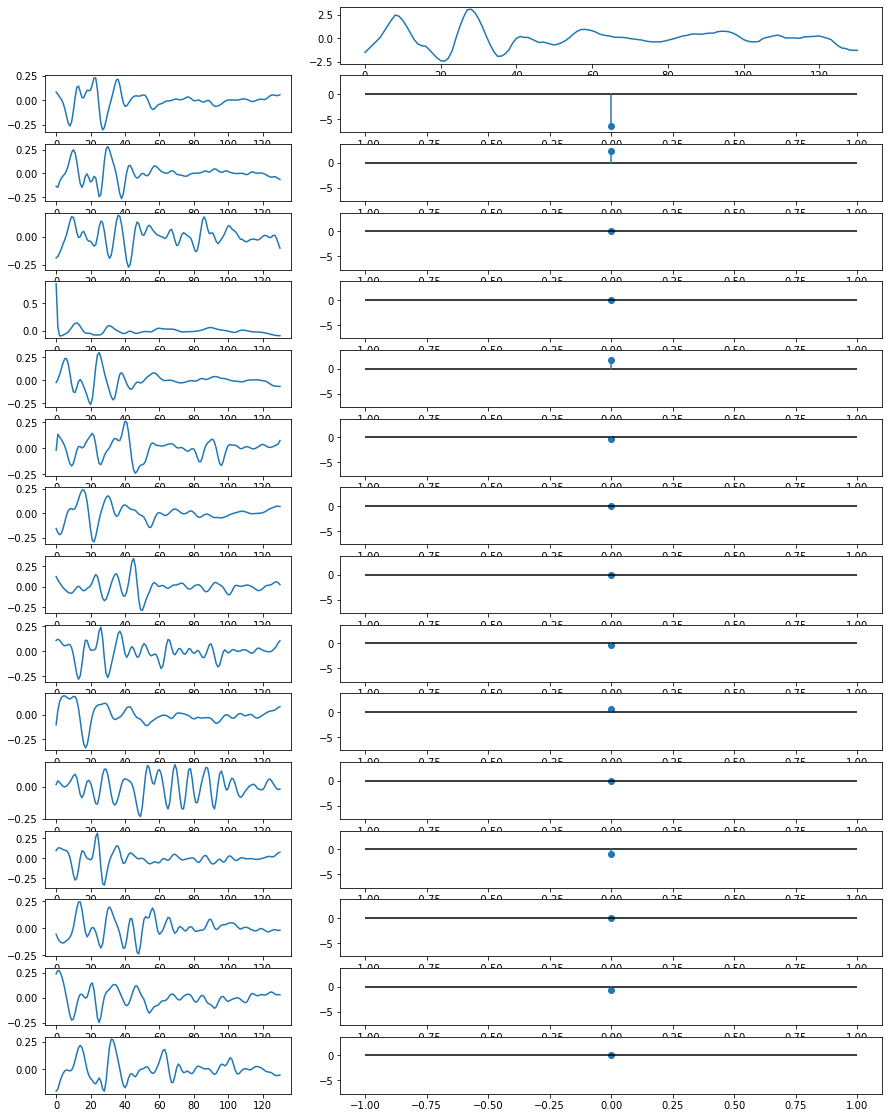

In [30]:
from online_learning.metrics import sparsity_ratio
import numpy as np
import matplotlib.pyplot as plt

def plot_DL(signal, Z, D, figsize=(15, 20)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    margin_y = 0.15 * (np.max(Z) - np.min(Z))
    min_y, max_y = np.min(Z) - margin_y, np.max(Z) + margin_y
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
#        plt.plot(Z[:, i])
        plt.scatter(0, Z[i])
        plt.plot([0, 0], [0, Z[i]])
        plt.ylim((min_y, max_y))
#        plt.hlines(0, 0, Z[:, i].shape[0], color="k")
        plt.hlines(0, -1, 1, color="k")
    plt.show()
        

X_transformed = dict_learner.transform(X)
D = dict_learner.components_

print(X.shape, X_transformed.shape, D.shape)

ind = 102
print("Label:", y[ind])
plot_DL(X[ind, :], X_transformed[ind,:].T, D.T)

## Fashion MNIST dataset

In [ ]:
import numpy as np
import time
from sklearn.decomposition import MiniBatchDictionaryLearning
from online_learning.visualizations import show_dictionary_atoms_img
from online_learning.datasets import make_fashion_mnist
from online_learning.utils import show_imgs, add_text_on_image
from online_learning.inpainting import infer_img, forge_and_reconstruct
from online_learning.metrics import l2_images_error

We use the FashionMNIST dataset here, which is composed of 60000 images of clothes, each image being of size 28x28, so that it can be reshaped as a feature of size 784.

In [25]:
train_size = 10000
test_size = 1000

X_fashion, X_fashion_test = make_fashion_mnist(train_size, test_size)
X_fashion = X_fashion
X_fashion_test = X_fashion_test

print(f"Shape of the train dataset: {X_fashion.shape}")
print(f"Shape of the test dataset : {X_fashion_test.shape}")

Shape of the train dataset: (10000, 784)
Shape of the test dataset : (1000, 784)


We fit a multi batch dictionary using the method proposed in the article. We then visualize the obtained atoms at the end of this fit.

[dict_learning] ........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

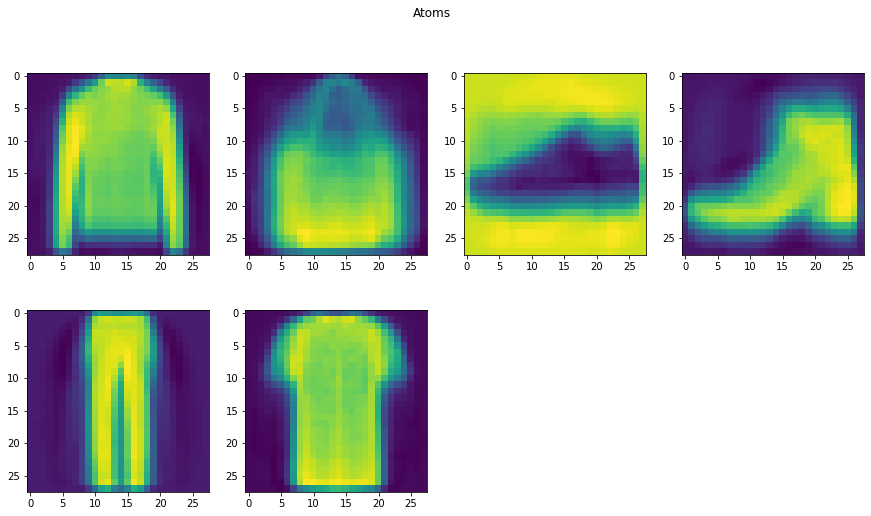

In [12]:
n_atoms = 6
dict_learner_6_atoms = MiniBatchDictionaryLearning(
    n_components=n_atoms, transform_algorithm='lasso_lars',
    random_state=42, verbose=True,
    batch_size=5,
).fit(X_fashion)

show_dictionary_atoms_img(dict_learner_6_atoms)

We can then take an image and compute its sparse decomposition on the dictionary.

L2 error between original image and its reconstruction: 8.066844293683676


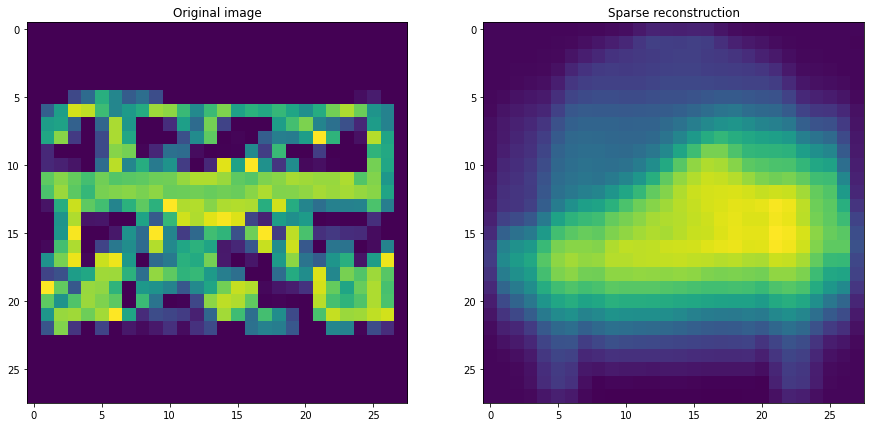

In [13]:
img = np.reshape(X_fashion_test[0], (28, 28))
img_hat = infer_img(img, dict_learner_6_atoms)

print("L2 error between original image and its reconstruction:", l2_images_error(img, img_hat))
show_imgs([img, img_hat], ["Original image", "Sparse reconstruction"])

It seems that we don't have enough atoms to fit the variety of objects. Let us increase this number

[dict_learning] ........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

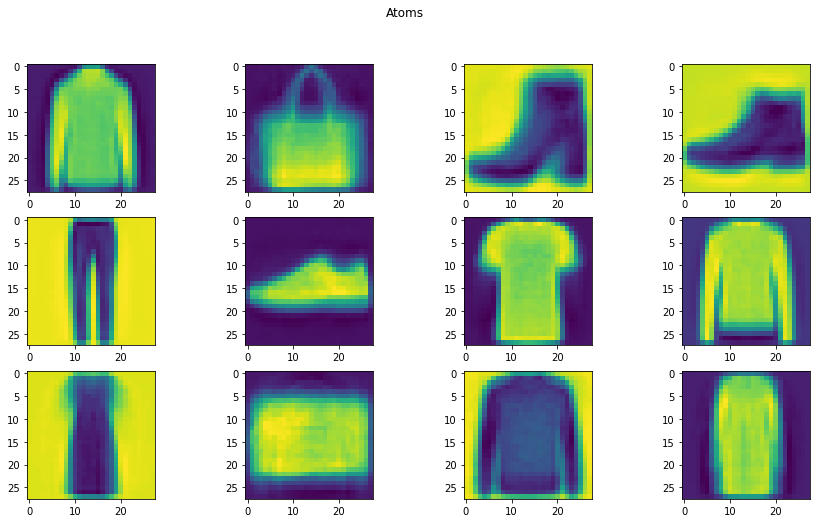

In [14]:
n_atoms = 12
dict_learner_12_atoms = MiniBatchDictionaryLearning(
    n_components=n_atoms, transform_algorithm='lasso_lars',
    random_state=42, verbose=True,
    batch_size=5,
).fit(X_fashion)

show_dictionary_atoms_img(dict_learner_12_atoms)

L2 error between original image and its reconstruction: 7.27213919357477


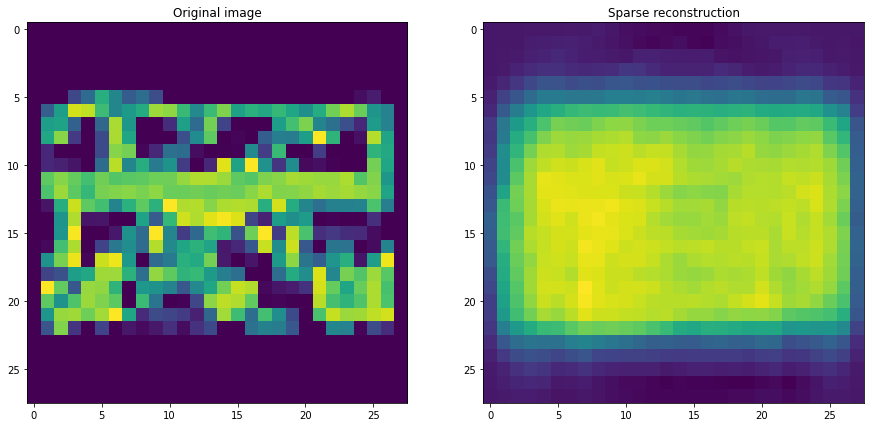

In [15]:
img = np.reshape(X_fashion_test[0], (28, 28))
img_hat = infer_img(img, dict_learner_12_atoms)

print("L2 error between original image and its reconstruction:", l2_images_error(img, img_hat))
show_imgs([img, img_hat], ["Original image", "Sparse reconstruction"])

The result is already better, the shape being closer. Let us increase once again the number of atoms.

[dict_learning] ........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

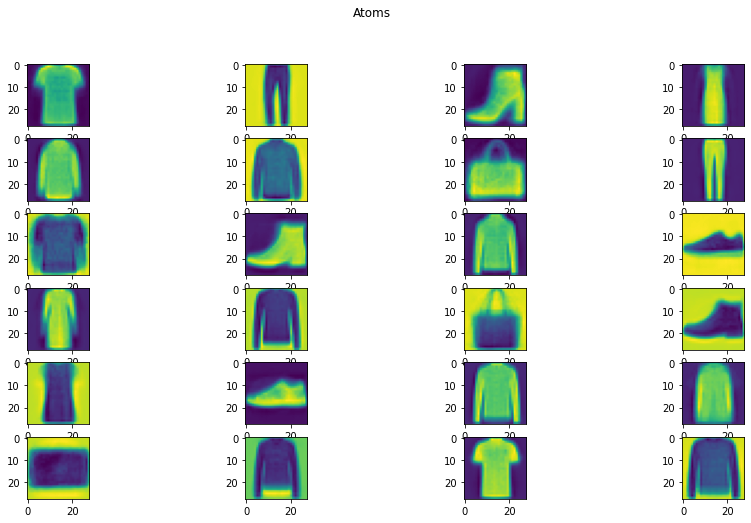

In [16]:
n_atoms = 24
dict_learner_24_atoms = MiniBatchDictionaryLearning(
    n_components=n_atoms, transform_algorithm='lasso_lars',
    random_state=42, verbose=True,
    batch_size=5,
).fit(X_fashion)

show_dictionary_atoms_img(dict_learner_24_atoms)

L2 error between original image and its reconstruction: 7.220685608999744


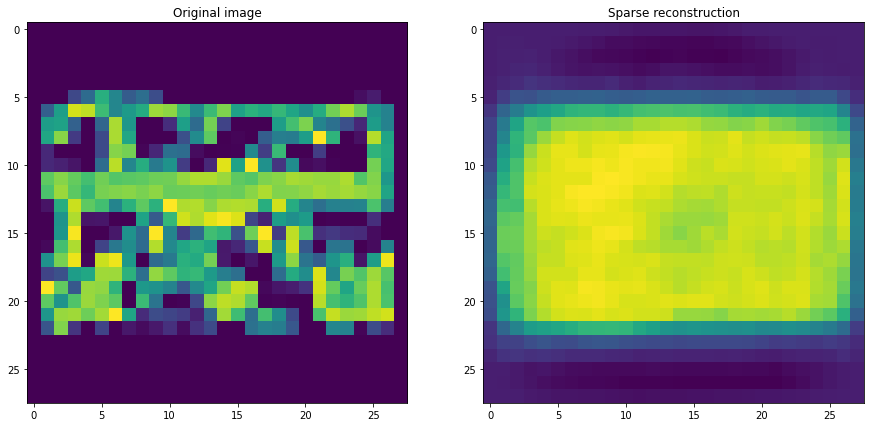

In [17]:
img = np.reshape(X_fashion_test[0], (28, 28))
img_hat = infer_img(img, dict_learner_24_atoms)

print("L2 error between original image and its reconstruction:", l2_images_error(img, img_hat))
show_imgs([img, img_hat], ["Original image", "Sparse reconstruction"])

In [37]:
n_atoms = 300
dict_learner_300_atoms = MiniBatchDictionaryLearning(
    n_components=n_atoms, transform_algorithm='lasso_lars',
    random_state=42, verbose=False,
    batch_size=5,
).fit(X_fashion)

/Users/thomas/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:622: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.360e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


L2 error between original image and its reconstruction: 7.0855162584196005


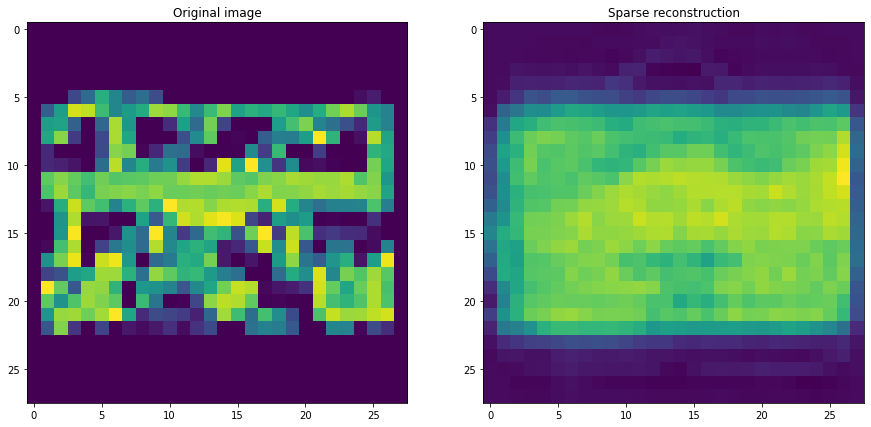

In [38]:
img = np.reshape(X_fashion_test[0], (28, 28))
img_hat = infer_img(img, dict_learner_300_atoms)

print("L2 error between original image and its reconstruction:", l2_images_error(img, img_hat))
show_imgs([img, img_hat], ["Original image", "Sparse reconstruction"])

Our example is underrepresented in the dataset so it may require an extremely large amount of atoms to be well reconstructed, making sparsity less interesting here than the original image. 

We confirm it in the next cells, where we fit a dictionary with 700 atoms on the signal, which is nearly the size of the image. The result being of poor quality, it is not interesting here to consider a dictionary decomposition as there would still be as many weights to consider, so the signal would not be compressed.

In [26]:
n_atoms = 700
start_time = time.time()
dict_learner_700_atoms = MiniBatchDictionaryLearning(
    n_components=n_atoms, transform_algorithm='lasso_lars',
    random_state=42, verbose=False,
    batch_size=5,
).fit(X_fashion)
print(f"Took {time.time() - start_time}s to compute a dictionary of {n_atoms} atoms.")

/Users/thomas/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:622: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.426e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/thomas/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:622: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.423e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/thomas/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:622: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.420e-03, with 

Took 161.4053041934967s to compute a dictionary of 700 atoms.


L2 error between original image and its reconstruction: 6.966957243605123


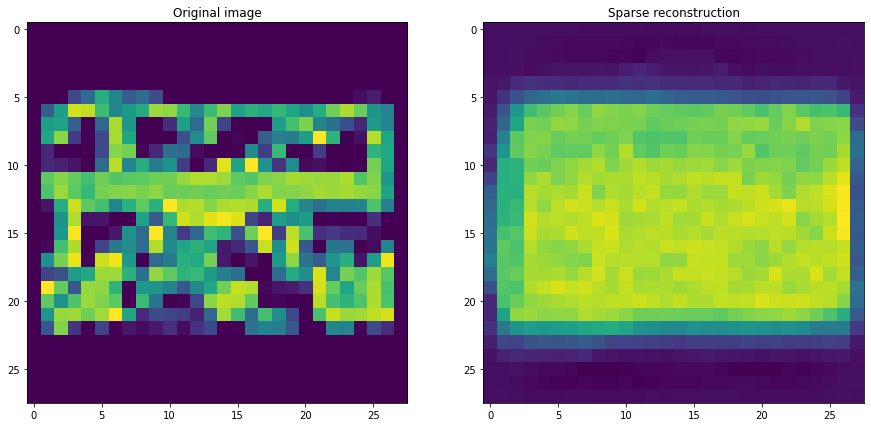

In [27]:
img = np.reshape(X_fashion_test[0], (28, 28))
img_hat = infer_img(img, dict_learner_700_atoms)

print("L2 error between original image and its reconstruction:", l2_images_error(img, img_hat))
show_imgs([img, img_hat], ["Original image", "Sparse reconstruction"])

Let us then take a look at another more usual picture.

L2 error between original image and its reconstruction with 6 atoms: 4.250790635684638


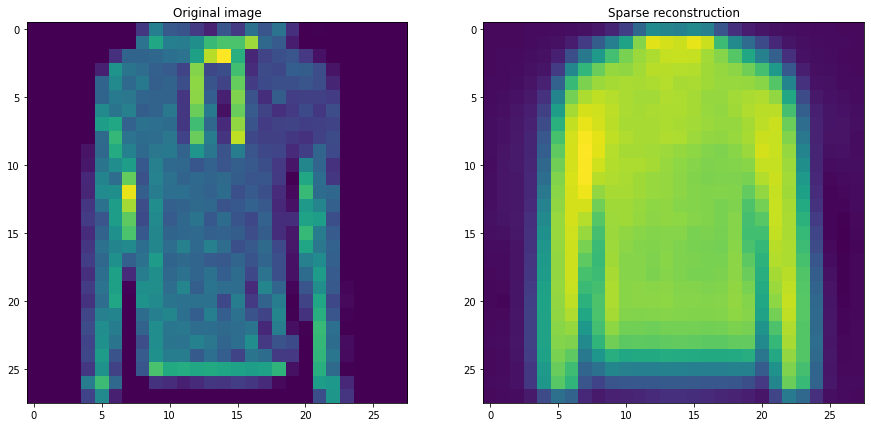

L2 error between original image and its reconstruction with 12 atoms: 4.152308750674839


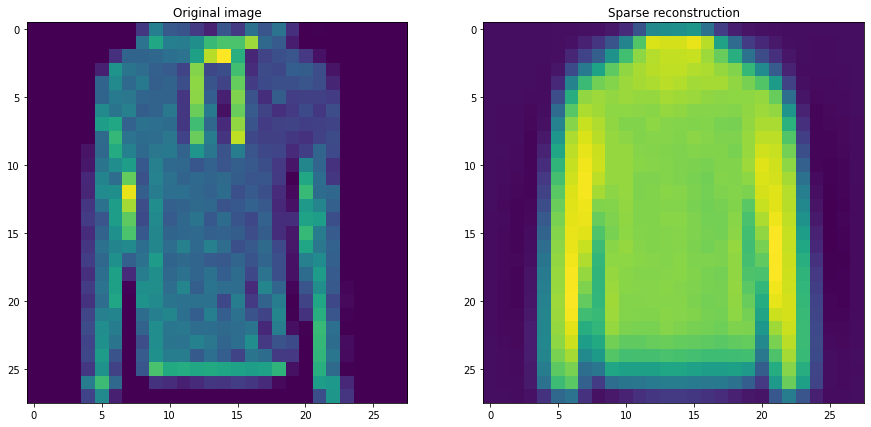

L2 error between original image and its reconstruction with 24 atoms: 3.984636779120258


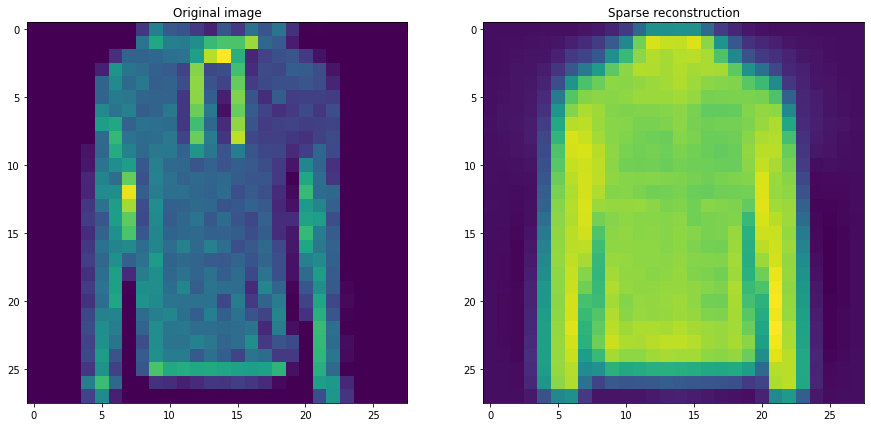

L2 error between original image and its reconstruction with 120 atoms: 3.5409912786526174


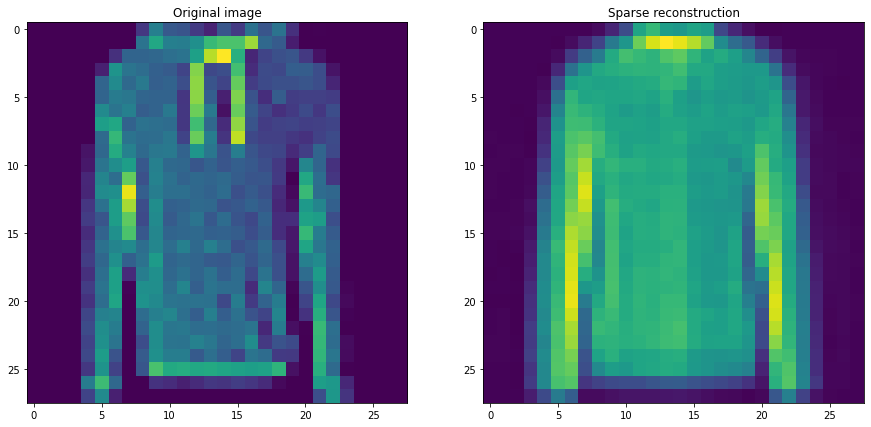

L2 error between original image and its reconstruction with 300 atoms: 3.6192349929923173


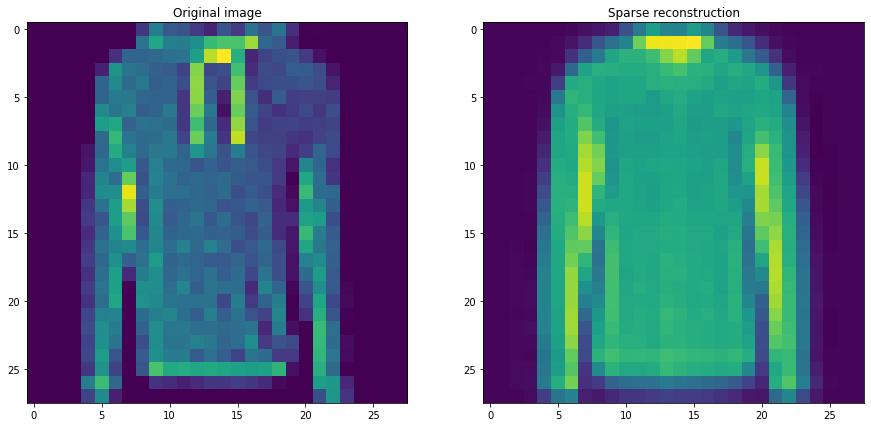

L2 error between original image and its reconstruction with 700 atoms: 3.6137969620392996


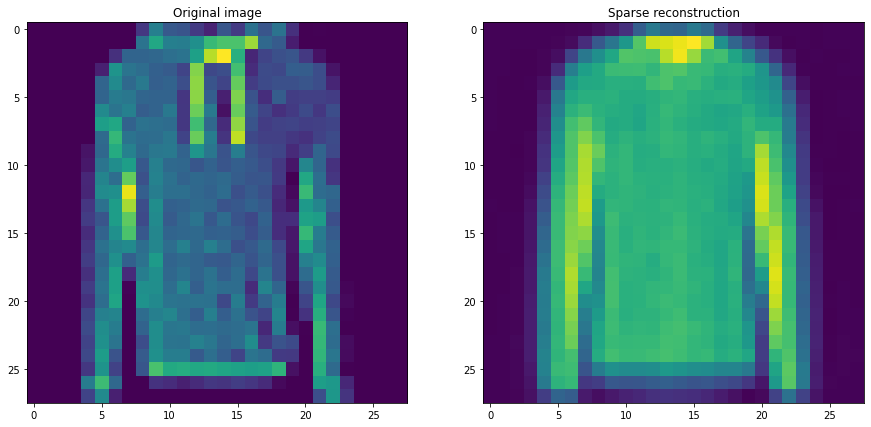

In [46]:
img = np.reshape(X_fashion_test[6], (28, 28))

dictionaries = [
    dict_learner_6_atoms,
    dict_learner_12_atoms,
    dict_learner_24_atoms,
    dict_learner_120_atoms,
    dict_learner_300_atoms, 
    dict_learner_700_atoms
]
n_atoms = [6, 12, 24, 120, 300, 700]

for idx, dictionary in enumerate(dictionaries):
    img_hat0 = infer_img(img, dictionary)
    print("=" * 30)
    print(f"L2 error between original image and its reconstruction with {n_atoms[idx]} atoms:", l2_images_error(img, img_hat0))
    show_imgs([img, img_hat0], ["Original image", "Sparse reconstruction"])

We still lack details but we get the general shape of the sweater, and the reconstruction gets more accurate as we increase the number of atoms. Yet, the reconstruction error plateaus at a high value which does not seem to decrease fast enough, so the dictionary learning may not be relevant to fully reconstruct the image here but rather to give the general idea about what the content of the image should be.

## Inpainting with the dictionary

Let's pick an image and add text on it. We obtain a forged image, which we then try to reconstruct using our previously learnt dictionaries. This is an inpainting step.

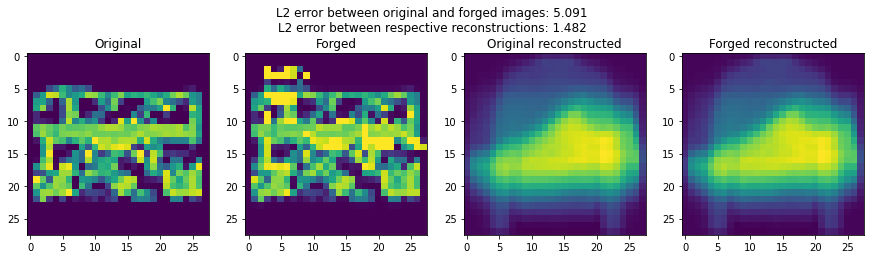

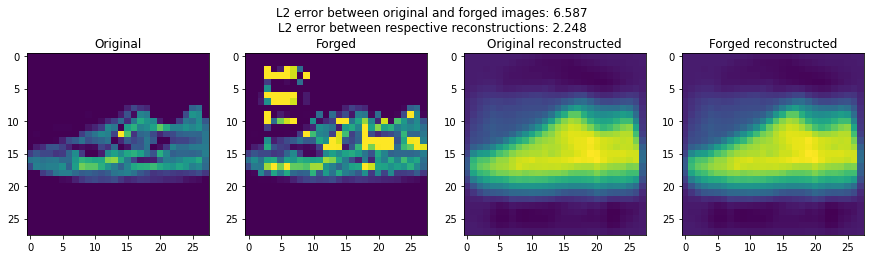

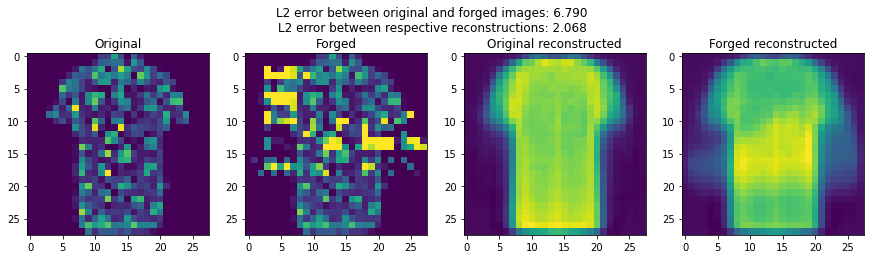

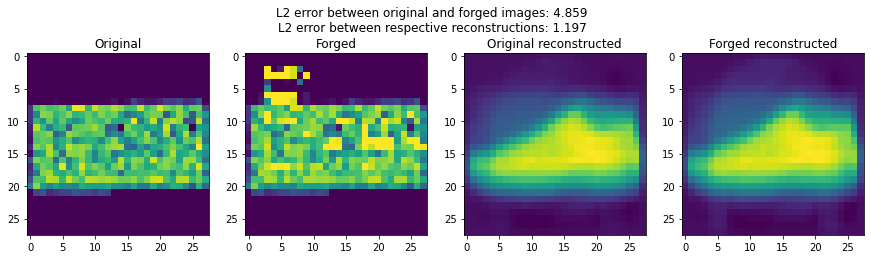

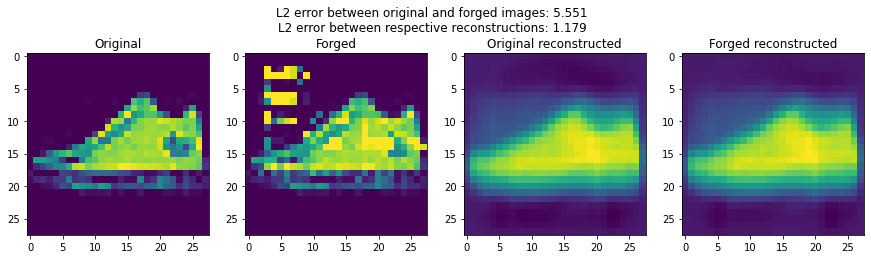

In [97]:
text = ['Hello', 'there!', "How are you?", "I'm fine thanks!", "See you soon."]

for img_idx in range(5):
    img = np.reshape(X_fashion_test[img_idx], (28, 28))
    _, _, _ = forge_and_reconstruct(img, dict_learner_6_atoms, text)

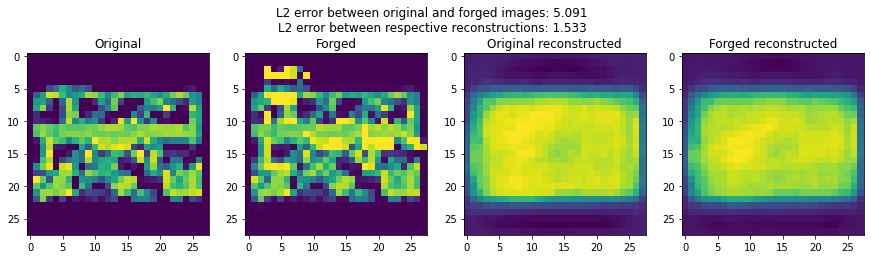

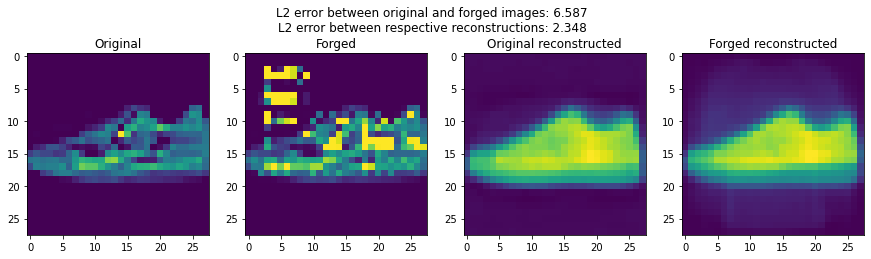

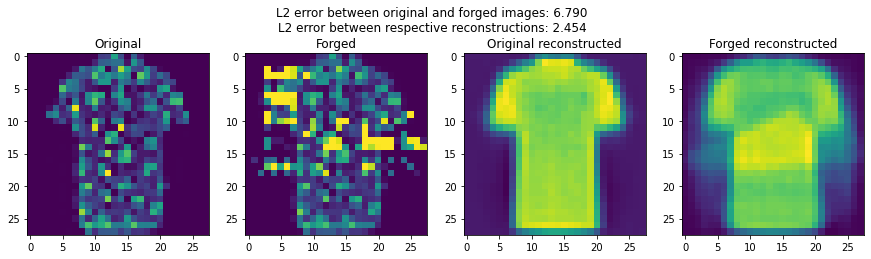

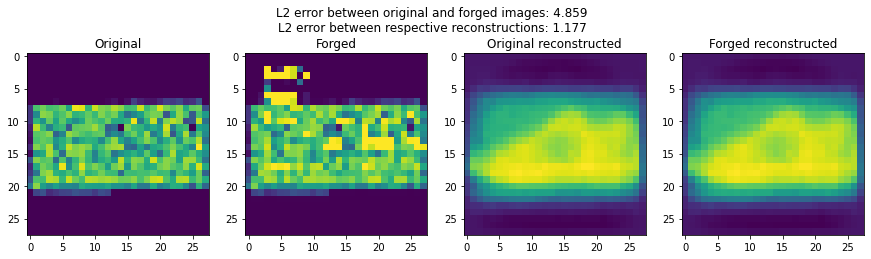

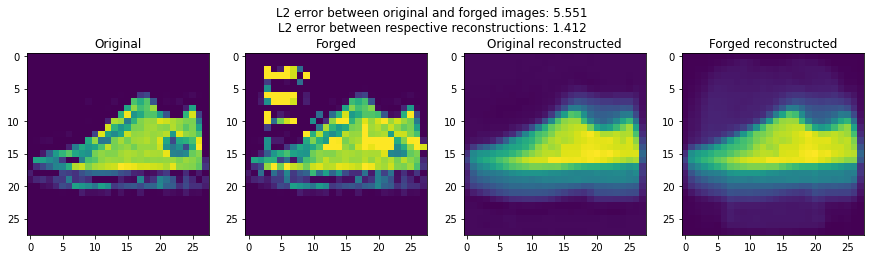

In [93]:
for img_idx in range(5):
    img = np.reshape(X_fashion_test[img_idx], (28, 28))
    _, _, _ = forge_and_reconstruct(img, dict_learner_24_atoms, text)

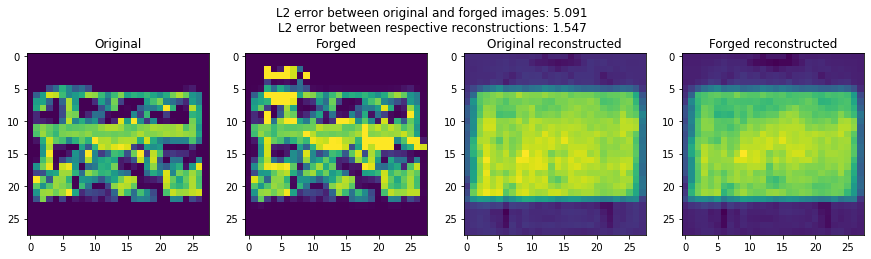

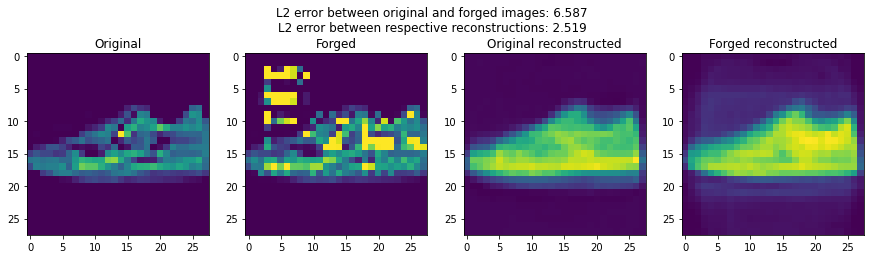

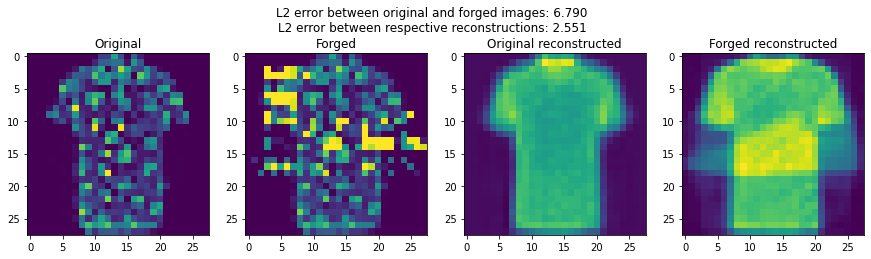

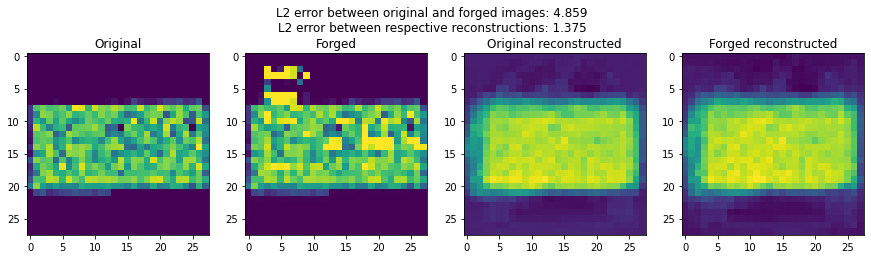

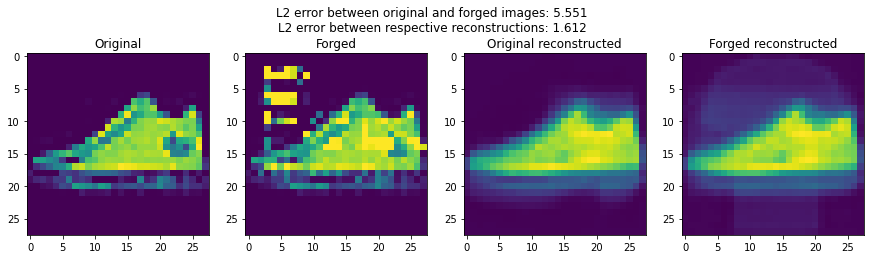

In [96]:
for img_idx in range(5):
    img = np.reshape(X_fashion_test[img_idx], (28, 28))
    _, _, _ = forge_and_reconstruct(img, dict_learner_120_atoms, text)

# Online learning with changing dataset

Files already downloaded and verified
Train dataset of shape: (13000, 3072)
Test dataset of shape: (100, 3072)


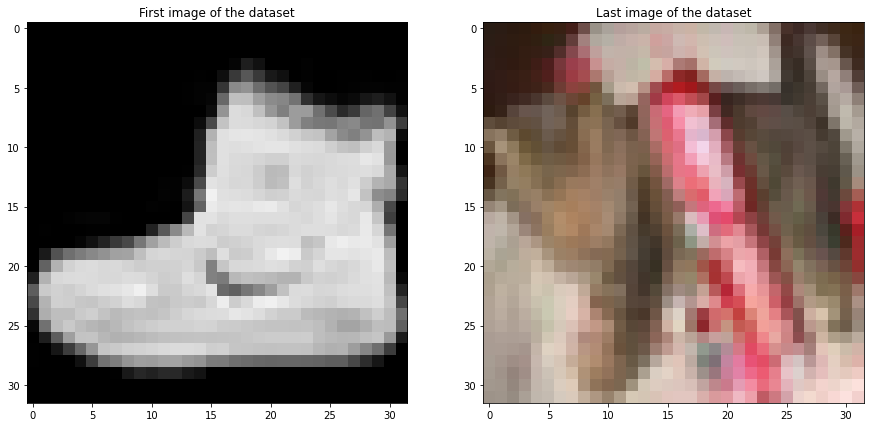

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from online_learning.datasets import make_mix_fashion_mnist_cifar10
from online_learning.utils import show_imgs

n_samples_mnist = (8000, 100)
n_samples_cifar = (8000, 100)
X_train, X_test = make_mix_fashion_mnist_cifar10(n_samples_mnist, n_samples_cifar, "cat")

print(f"Train dataset of shape: {X_train.shape}\nTest dataset of shape: {X_test.shape}")
img0 = np.reshape(X_train[0], (32, 32, 3))
img1 = np.reshape(X_train[-1], (32, 32, 3))
show_imgs([img0, img1], ["First image of the dataset", "Last image of the dataset"])

# ONLINE LEARNING

In [10]:
import numpy as np
from online_learning.datasets import make_faces, make_sparse_data
from sklearn.decomposition import MiniBatchDictionaryLearning, DictionaryLearning
import matplotlib.pyplot as plt


def loader(X, batch_size):
    for j, i in enumerate(range(0, len(X), batch_size)):
        try:
            yield j, X[i:i+batch_size]
        except IndexError:
            yield j, X[i:]


X = make_sparse_data(n_samples=250000,
                     n_features=1000,  # length of the signal
                     n_components=10,
                     random_state=42).T
# X, __ = make_faces()

In [2]:
## dictionary stabilisation

out = []

for j in range(3,8):
    n_components = j
    batch_size = 5
    verbose = 0
    d = np.random.randn(n_components, X.shape[1])
    clf = MiniBatchDictionaryLearning(n_components=n_components,
                                      batch_size=batch_size,
                                      # dict_init=d,
                                      verbose=verbose)

    for i, sample in loader(X, batch_size):
        clf.partial_fit(sample)
        if verbose:
            print()
        if np.allclose(d, clf.components_, atol=1e-4):  # dict == previous dict
            # pass
            print(i)
            out.append([j, i*batch_size])
            break
        d = clf.components_.copy()

plt.scatter(*np.array(out).T)
plt.xlabel("Parameter")
plt.ylabel("Nb of samples until stable")
plt.show()

445
1596
2058


KeyboardInterrupt: 

100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


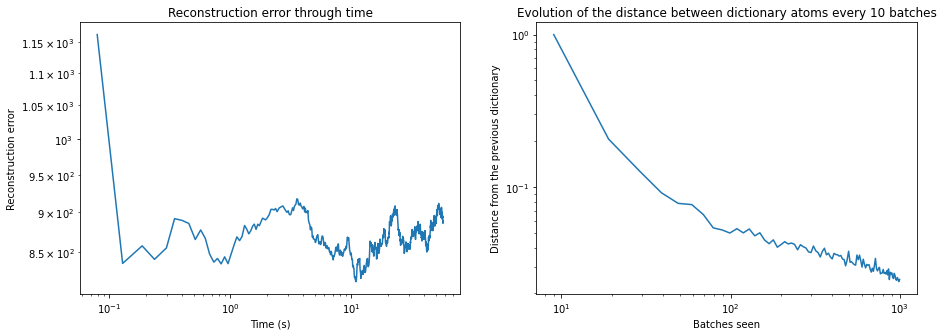

In [76]:
# Fashion MNIST
from online_learning.visualizations import show_dictionary_atoms_img
from online_learning.datasets import make_fashion_mnist
from online_learning.metrics import distance_between_dictionaries, distance_between_atoms
import time
from tqdm import tqdm


train_size = 30000
test_size = 1000

X, X_fashion_test = make_fashion_mnist(train_size, test_size)
test_x = X_fashion_test[0].reshape(1, -1)



## convergence of reconstruction

out = []
times = []
dictionary_atoms_distances, batches_seen = [], []
compute_atoms_distance_every = 10
display_intermediate = False



n_components = 10
batch_size = 30
verbose = 0
clf = MiniBatchDictionaryLearning(n_components=n_components,
                                  batch_size=batch_size,
                                  transform_algorithm='lasso_lars',
                                  # dict_init=d,
                                  verbose=verbose)
"""clf_all_X = MiniBatchDictionaryLearning(n_components=n_components,
                                  batch_size=3,
                                  transform_algorithm='lasso_lars',
                                  # dict_init=d,
                                  verbose=verbose)
clf_all_X.fit(X)
single_fit_bound = np.linalg.norm(test_x - clf_all_X.transform(test_x).dot(clf_all_X.components_))
"""



former_atoms = np.zeros((n_components, test_x.shape[1]))

start = time.time()
for i, sample in tqdm(loader(X, batch_size), total=X.shape[0] // batch_size):
    clf.partial_fit(sample)
    if verbose:
        print()
    s = np.linalg.norm(test_x - clf.transform(test_x).dot(clf.components_))
    out.append(s)
    times.append(time.time() - start)
    if s < 1e-6:
        break

    if i%compute_atoms_distance_every == compute_atoms_distance_every-1:
        distance_from_prev_dict = distance_between_atoms(former_atoms, clf.components_)
        former_atoms = np.copy(clf.components_)
        dictionary_atoms_distances.append(distance_from_prev_dict)
        batches_seen.append(i)
        
        if display_intermediate:
            print("=" * 20, "\n", "Batch", i)
            print("Distance between current and previous atoms:", distance_from_prev_dict)
            show_dictionary_atoms_img(clf)




fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))

ax0.loglog(times, out)
#ax0.hlines(single_fit_bound, times[0], times[-1], color="k")
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Reconstruction error")
ax0.set_title("Reconstruction error through time")

ax1.loglog(batches_seen, dictionary_atoms_distances)
ax1.set_xlabel("Batches seen")
ax1.set_ylabel("Distance from the previous dictionary")
ax1.set_title(f"Evolution of the distance between dictionary atoms every {compute_atoms_distance_every} batches")

plt.show()